# Example Sensor Data Analytics Notebook
Examples of sensor telemetry analysis, using line charts, scatter plots, and histograms.  
The data shows several distinct patterns and sensor anomalies, which can be analyzed, for example:
1. Sensor anomalies in the data to be recorded
2. Consistent cooling and heating pattern as a result of the HVAC system
3. Very different 'micro-climates' between the some of the locations
4. General stability of temperature and humidity in one location versus the other
5. Impact of human activities on each location's temperature and hummidity

In [1]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import pymongo
from dateutil import tz
from dotenv import load_dotenv
from matplotlib.dates import DateFormatter
from scipy.stats import norm

%matplotlib inline

## Load Environment Variables and Establish MongoDB Atlas Connection

In [2]:
%%time
# load env vars from local .env file
load_dotenv()

# establish db connection
MONGODB_CONN = os.environ.get('MONGODB_CONN')
MONGODB_DB = os.environ.get('MONGODB_DB')
MONGODB_COL = os.environ.get('MONGODB_COL')

client = pymongo.MongoClient(MONGODB_CONN)
db = client[MONGODB_DB]
iot_data = db[MONGODB_COL]

CPU times: user 56.3 ms, sys: 10 ms, total: 66.3 ms
Wall time: 189 ms


### Define Panda DataFrames for Two DHT Sensors
Panda DataFrames:
1. DataFrame 1: df1 = rp59adf374
2. DataFrame 2: df2 = rp829c7e0e
3. DataFrame 3: df3 = rp47a3d9f5

In [3]:
DEVICE_1 = 'rp59adf374'
DEVICE_2 = 'rp829c7e0e'
DEVICE_3 = 'rp47a3d9f5'

### DataFrame 1

In [4]:
%%time
# aggregation created and exported from MongoDB Compass
# ~72-hour period from 5/11/2019 8:00:00 PM - 5/14/2019 8:00:00 PM
pipeline = [
    {
        '$match': {
            'type': 'DHT22', 
            'device': DEVICE_1, 
            'timestamp': {
                '$gt': 1557619200,
                '$lt': 1557878400
            }
        }
    }, {
        '$project': {
            '_id': 0,
            'timestamp': 1, 
            'temperature': '$data.temperature', 
            'humidity': '$data.humidity'
        }
    }, {
        '$sort': {
            'timestamp': 1
        }
    }
]
aggResult = iot_data.aggregate(pipeline)
df1 = pd.DataFrame(list(aggResult))

# convert celsius to fahrenheit
df1['temperature'] = ((df1.temperature * 1.8) + 32)

# attempt to remove outliers (sensor anomalies)
qt = df1['temperature'].quantile(0.01)
df1 = df1[df1['temperature'] >= qt]
qh = df1['humidity'].quantile(0.01)
df1 = df1[df1['humidity'] >= qh]

# convert timestamps to datetime
df1['timestamp'] = pd.to_datetime(df1['timestamp'], unit='s')
df1['timestamp'] = df1.timestamp.dt.tz_localize('UTC').dt.tz_convert('US/Eastern')

CPU times: user 200 ms, sys: 26.5 ms, total: 226 ms
Wall time: 7 s


In [5]:
df1.head()

,humidity,temperature,timestamp
0,71.599998,61.160001,2019-05-11 20:00:17.621932030-04:00
1,71.699997,60.980001,2019-05-11 20:00:44.419905901-04:00
2,71.800003,61.160001,2019-05-11 20:01:06.264283895-04:00
3,71.800003,61.160001,2019-05-11 20:01:38.189882040-04:00
4,71.900002,61.160001,2019-05-11 20:02:07.564734936-04:00


In [6]:
df1['temperature'].describe()

count    10202.000000
mean        62.588108
std          0.721796
min         60.980001
25%         62.060001
50%         62.419999
75%         62.960001
max         64.939999
Name: temperature, dtype: float64

In [7]:
df1['humidity'].describe()

count    10202.000000
mean        67.854901
std          1.696223
min         63.700001
25%         66.800003
50%         68.000000
75%         69.000000
max         73.000000
Name: humidity, dtype: float64

### DataFrame 2

In [8]:
%%time
# aggregation created and exported from MongoDB Compass
# ~72-hour period from 5/11/2019 8:00:00 PM - 5/14/2019 8:00:00 PM
pipeline = [
    {
        '$match': {
            'type': 'DHT22', 
            'device': DEVICE_2, 
            'timestamp': {
                '$gt': 1557619200,
                '$lt': 1557878400
            }
        }
    }, {
        '$project': {
            '_id': 0,
            'timestamp': 1, 
            'temperature': '$data.temperature', 
            'humidity': '$data.humidity'
        }
    }, {
        '$sort': {
            'timestamp': 1
        }
    }
]
aggResult = iot_data.aggregate(pipeline)
df2 = pd.DataFrame(list(aggResult))

# convert celsius to fahrenheit
df2['temperature'] = ((df2.temperature * 1.8) + 32)

# attempt to remove outliers (sensor anomalies)
qt = df2['temperature'].quantile(0.01)
df2 = df2[df2['temperature'] >= qt]
qh = df2['humidity'].quantile(0.01)
df2 = df2[df2['humidity'] >= qh]

# convert timestamps to datetime
df2['timestamp'] = pd.to_datetime(df2['timestamp'], unit='s')
df2['timestamp'] = df2.timestamp.dt.tz_localize('UTC').dt.tz_convert('US/Eastern')

CPU times: user 203 ms, sys: 19.5 ms, total: 222 ms
Wall time: 4.06 s


In [9]:
df2.head()

,humidity,temperature,timestamp
0,49.200001,70.519999,2019-05-11 20:00:05.271175623-04:00
1,49.200001,70.519999,2019-05-11 20:00:29.119190216-04:00
2,49.200001,70.519999,2019-05-11 20:00:47.883913517-04:00
3,49.200001,70.519999,2019-05-11 20:01:17.128739834-04:00
4,49.200001,70.519999,2019-05-11 20:01:35.792525291-04:00


In [10]:
df2['temperature'].describe()

count    10990.000000
mean        69.927687
std          0.636139
min         68.360001
25%         69.439999
50%         69.890000
75%         70.339999
max         71.780001
Name: temperature, dtype: float64

In [11]:
df2['humidity'].describe()

count    10990.000000
mean        49.999663
std          1.113874
min         48.400002
25%         49.200001
50%         49.599998
75%         51.000000
max         53.700001
Name: humidity, dtype: float64

### DataFrame 3

In [12]:
%%time
# aggregation created and exported from MongoDB Compass
# ~32-hour period
# 2019-05-17 21:58:04.746520996-04:00
# 2019-05-19 07:59:55.743566036-04:00
pipeline = [
    {
        '$match': {
            'type': 'DHT22', 
            'device': DEVICE_3, 
            'timestamp': {
                '$gt': 1558094400,
                '$lt': 1558267200
            }
        }
    }, {
        '$project': {
            '_id': 0, 
            'timestamp': 1, 
            'temperature': '$data.temperature', 
            'humidity': '$data.humidity'
        }
    }, {
        '$sort': {
            'timestamp': 1
        }
    }
]
aggResult = iot_data.aggregate(pipeline)
df3 = pd.DataFrame(list(aggResult))

# convert celsius to fahrenheit
df3['temperature'] = ((df3.temperature * 1.8) + 32)

# attempt to remove outliers (sensor anomalies)
qt = df3['temperature'].quantile(0.01)
df3 = df3[df3['temperature'] >= qt]
qh = df3['humidity'].quantile(0.01)
df3 = df3[df3['humidity'] >= qh]

# convert timestamps to datetime
df3['timestamp'] = pd.to_datetime(df3['timestamp'], unit='s')
df3['timestamp'] = df3.timestamp.dt.tz_localize('UTC').dt.tz_convert('US/Eastern')

CPU times: user 113 ms, sys: 9.6 ms, total: 123 ms
Wall time: 3.39 s


In [13]:
df3.head()
# df3.tail()

,humidity,temperature,timestamp
0,55.400002,68.180001,2019-05-17 21:58:04.746520996-04:00
1,55.000000,68.180001,2019-05-17 21:58:44.161487103-04:00
2,55.400002,68.180001,2019-05-17 21:59:20.773802042-04:00
3,55.400002,68.180001,2019-05-17 21:59:49.795339108-04:00
4,55.599998,68.180001,2019-05-17 22:00:11.719543934-04:00


In [14]:
df3['temperature'].describe()

count    4984.000000
mean       67.265012
std         0.342777
min        66.739999
25%        66.919999
50%        67.280001
75%        67.639999
max        68.180001
Name: temperature, dtype: float64

In [15]:
df3['humidity'].describe()

count    4984.000000
mean       53.943399
std         1.702075
min        47.400002
25%        52.799999
50%        53.799999
75%        55.400002
max        57.099998
Name: humidity, dtype: float64

### Temperature Graphs using Moving Average
* Using Pandas `pandas.DataFrame.plot`
* Smoothing data using the mean average of a 5 minute rolling window (moving average)
* 5 minutes = (20) data-points @ 15 second intervals (4/min)
* Reference: https://en.wikipedia.org/wiki/Moving_average

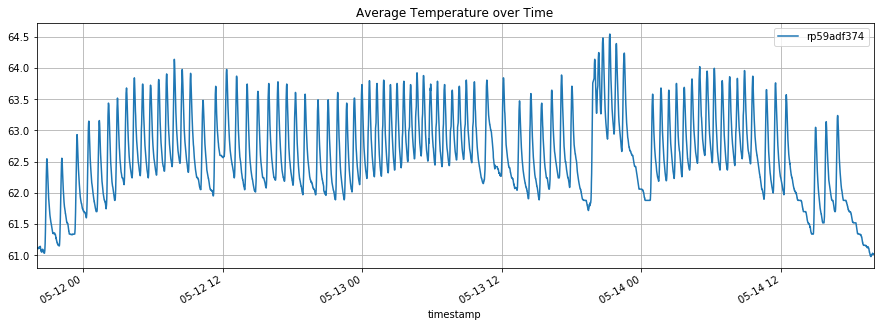

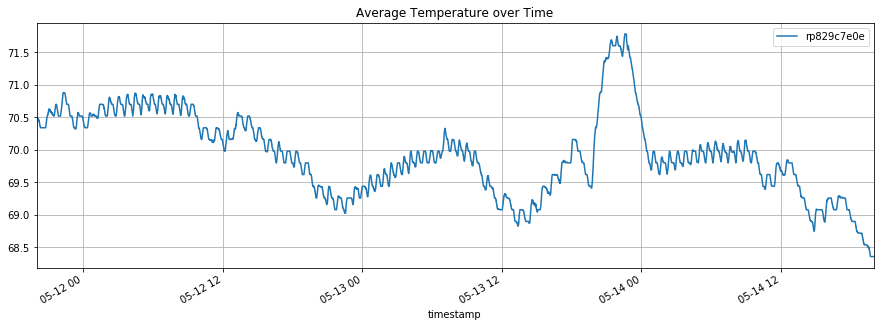

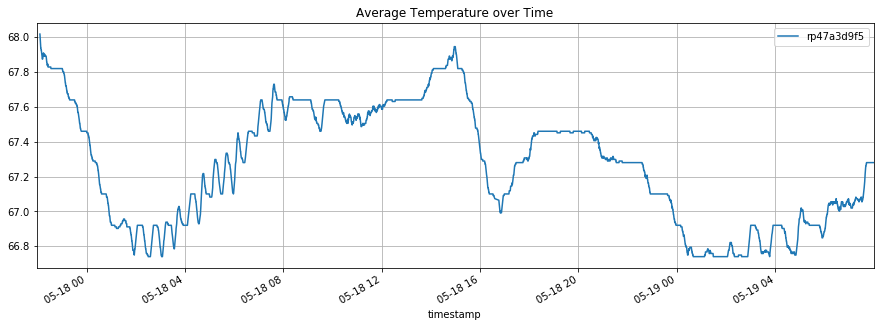

In [16]:
df1['mean'] = df1['temperature'].rolling(window=20).mean()
line1 = df1.plot.line(x='timestamp', 
                             y=['mean'], 
                             figsize=(15, 5), 
                             label=[DEVICE_1], 
                             title='Average Temperature over Time',
                             grid=True)

df2['mean'] = df2['temperature'].rolling(window=20).mean()
line2 = df2.plot.line(x='timestamp', 
                             y=['mean'], 
                             figsize=(15, 5), 
                             label=[DEVICE_2],
                             title='Average Temperature over Time',
                             grid=True)

df3['mean'] = df3['temperature'].rolling(window=20).mean()
line3 = df3.plot.line(x='timestamp', 
                             y=['mean'], 
                             figsize=(15, 5), 
                             label=[DEVICE_3],
                             title='Average Temperature over Time',
                             grid=True)

## Temperature and Humidity Comparisons
* Using `matplotlib.pyplot`
* Comparing two different device's data
* First temperature, then humidity

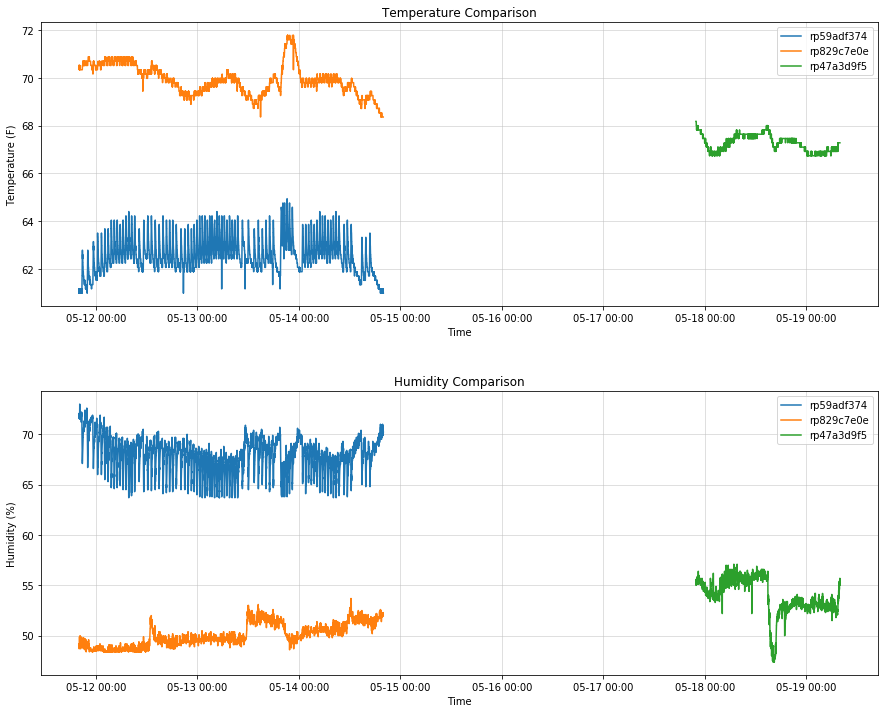

In [17]:
fig, ax = plt.subplots(2, 1, figsize=(15, 12))

ax[0].plot(df1['timestamp'], df1['temperature'], linestyle='solid', marker='None', label=DEVICE_1)
ax[0].plot(df2['timestamp'], df2['temperature'], linestyle='solid', marker='None', label=DEVICE_2)
ax[0].plot(df3['timestamp'], df3['temperature'], linestyle='solid', marker='None', label=DEVICE_3)
ax[0].xaxis.set_major_formatter(DateFormatter('%m-%d %H:%M', tz=tz.gettz('US/Eastern')))
ax[0].legend()
ax[0].set_title('Temperature Comparison')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Temperature (F)')
ax[0].grid(color='silver', linestyle='-', linewidth=1, alpha=0.5)

ax[1].plot(df1['timestamp'], df1['humidity'], linestyle='solid', marker='None', label=DEVICE_1)
ax[1].plot(df2['timestamp'], df2['humidity'], linestyle='solid', marker='None', label=DEVICE_2)
ax[1].plot(df3['timestamp'], df3['humidity'], linestyle='solid', marker='None', label=DEVICE_3)
ax[1].xaxis.set_major_formatter(DateFormatter('%m-%d %H:%M', tz=tz.gettz('US/Eastern')))
ax[1].legend()
ax[1].set_title('Humidity Comparison')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Humidity (%)')
ax[1].grid(color='silver', linestyle='-', linewidth=1, alpha=0.5)

fig.subplots_adjust(hspace=0.3)
plt.show()

### Scatter Plot Comparisons
* Using `matplotlib.pyplot`
* X Axis = temperature
* Y Axis = humidity

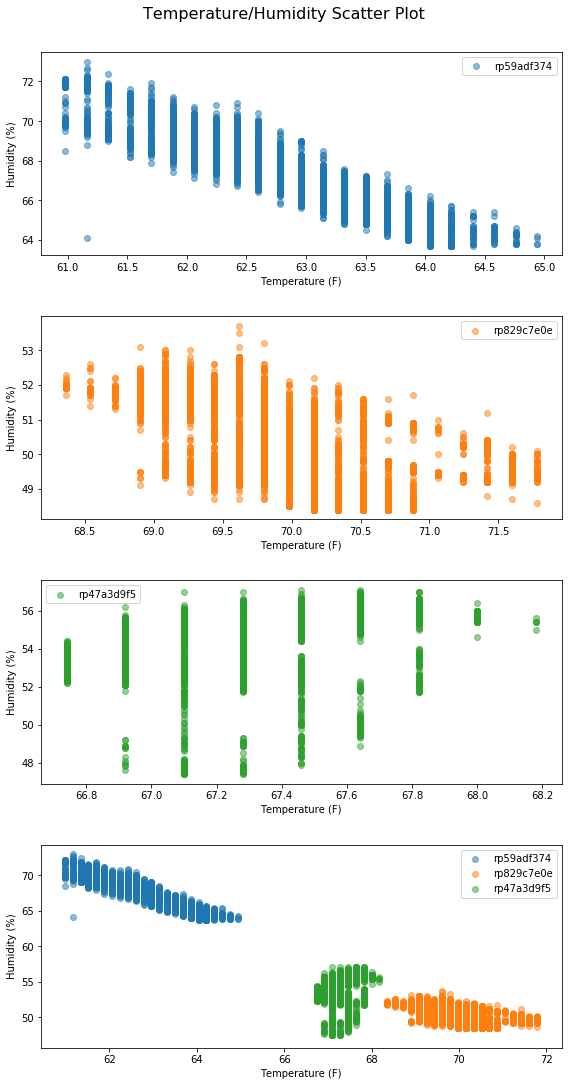

In [25]:
fig, ax = plt.subplots(4, 1, figsize=(8, 16))

ax[0].scatter(df1['temperature'], df1['humidity'], alpha=0.5, label=DEVICE_1, color='C0')
ax[0].legend()
ax[0].set_xlabel('Temperature (F)')
ax[0].set_ylabel('Humidity (%)')

ax[1].scatter(df2['temperature'], df2['humidity'], alpha=0.5, label=DEVICE_2, color='C1')
ax[1].legend()
ax[1].set_xlabel('Temperature (F)')
ax[1].set_ylabel('Humidity (%)')

ax[2].scatter(df3['temperature'], df3['humidity'], alpha=0.5, label=DEVICE_3, color='C2')
ax[2].legend()
ax[2].set_xlabel('Temperature (F)')
ax[2].set_ylabel('Humidity (%)')

ax[3].scatter(df1['temperature'], df1['humidity'], alpha=0.5, label=DEVICE_1, color='C0')
ax[3].scatter(df2['temperature'], df2['humidity'], alpha=0.5, label=DEVICE_2, color='C1')
ax[3].scatter(df3['temperature'], df3['humidity'], alpha=0.5, label=DEVICE_3, color='C2')
ax[3].legend()
ax[3].set_xlabel('Temperature (F)')
ax[3].set_ylabel('Humidity (%)')

fig.suptitle('Temperature/Humidity Scatter Plot', fontsize=16)
fig.tight_layout(rect=[0, 0.04, 1, 0.95])
fig.subplots_adjust(hspace=0.3)
plt.show()

### Histogram: Temperature Distribution
* Matplotlib Histogram using `matplotlib.pyplot.hist`
* Reference Code: https://pythonspot.com/matplotlib-histogram

dataframe: df1
data: temperature
mu (μ): 62.59
sigma (σ): 0.72


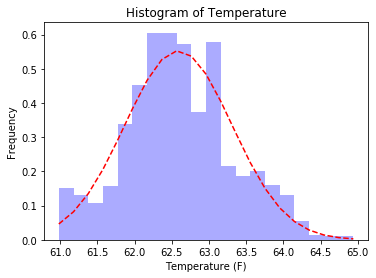

In [19]:
df = df1['temperature']

mu = df.mean() # mean of distribution
sigma = df.std() # standard deviation of distribution
x = df # data distribution
num_bins = 20

# the histogram of the data
n, bins, patches = plt.hist(x, num_bins, density=1, facecolor='blue', alpha=0.33)

# add a 'best fit' line
y = norm.pdf(bins, mu, sigma)
plt.plot(bins, y, 'r--')
plt.xlabel('Temperature (F)')
plt.ylabel('Frequency')
plt.title('Histogram of Temperature')

# output
print('dataframe: df1')
print('data: temperature')
print('mu (\u03BC): %.2f' % mu)
print('sigma (\u03C3): %.2f' % sigma)

# tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.show()

dataframe: df2
data: temperature
mu (μ): 69.93
sigma (σ): 0.64


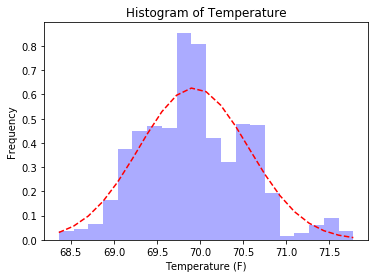

In [20]:
df = df2['temperature']

mu = df.mean() # mean of distribution
sigma = df.std() # standard deviation of distribution
x = df # data distribution
num_bins = 20

# the histogram of the data
n, bins, patches = plt.hist(x, num_bins, density=1, facecolor='blue', alpha=0.33)

# add a 'best fit' line
y = norm.pdf(bins, mu, sigma)
plt.plot(bins, y, 'r--')
plt.xlabel('Temperature (F)')
plt.ylabel('Frequency')
plt.title('Histogram of Temperature')

# output
print('dataframe: df2')
print('data: temperature')
print('mu (\u03BC): %.2f' % mu)
print('sigma (\u03C3): %.2f' % sigma)

# tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.show()